In [1]:
from pygmo import hypervolume
import csv
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
#### Modified from Pau's code
def compute_pareto_front(population):
    #print(np.shape(np.array(population)))
    #print(population)
    pop_size = len(population)
    obj_num = 2

    domination_counter = [0] * pop_size

    for i in range(pop_size):
        for j in range(i+1, pop_size):
            # check each objective for dominance
            dominate = [0] * obj_num
            for k in range(obj_num):
                if population[i][k] > population[j][k]:
                    dominate[k] = 1
                elif population[i][k] < population[j][k]:
                    dominate[k] = -1
            if -1 not in dominate and 1 in dominate:
                domination_counter[i] += 1
            elif -1 in dominate and 1 not in dominate:
                domination_counter[j] += 1

    pareto_solutions = []
    for i in range(len(domination_counter)):
        if domination_counter[i] == 0:
            pareto_solutions.append(population[i])
    return pareto_solutions

In [3]:
def read_csv_files(fib_stiff, epsilon_moea, run_num):

    filepath = 'C:\\SEAK Lab\\SEAK Lab Github\\KD3M3\\Truss_AOS\\result\\'
    if epsilon_moea:
        fileloc = 'Epsilon MOEA Runs\\'
        if fib_stiff:
            filename = 'Fibre Stiffness code run results\\EpsilonMOEA_emoea' + str(run_num) + '_fibrestiffness_fullpop.csv'
        else: 
            filename = 'Truss code run results\\EpsilonMOEA_emoea' + str(run_num) + '_trussstiffness_fullpop.csv'
    else:
        fileloc = 'AOS MOEA Runs\\'
        if fib_stiff:
            filename = 'Feas and Stab False\\Fibre Stiffness code run results\\AOSMOEA_constraint_adaptive' + str(run_num) + '_fibrestiffness_fullpop.csv'
        else: 
            filename = 'Feas and Stab False\\Truss code run results\\AOSMOEA_constraint_adaptive' + str(run_num) + '_trussstiffness_fullpop.csv' 

    full_filepath = filepath + fileloc + filename

    with open(full_filepath,newline='') as csvfile:
        data = [row for row in csv.reader(csvfile)]
        designs = ["" for x in range(len(data)-1)]
        num_func_evals = np.zeros(len(data)-1)
        pen_obj1 = np.zeros(len(data)-1)
        pen_obj2 = np.zeros(len(data)-1)
        feas_scores = np.zeros(len(data)-1)
        stab_scores = np.zeros(len(data)-1)
        for x in range(len(data)-1):
            designs[x] = data[x+1][0]
            num_func_evals[x] = int(data[x+1][1])
            pen_obj1[x] = float(data[x+1][2])
            pen_obj2[x] = float(data[x+1][3])
            feas_scores[x] = float(data[x+1][4])
            stab_scores[x] = float(data[x+1][5])
            
    return designs, num_func_evals, pen_obj1, pen_obj2, feas_scores, stab_scores

def compute_true_objectives(pen_obj1, pen_obj2, feas_score, stab_score, fib_stiff):
    pen_fac = 1
    if fib_stiff:
        pen_fac = 1.5
    pen = (np.log10(np.absolute(feas_score)) + np.log10(np.absolute(stab_score)))/2
    obj1 = 15*(pen_obj1 + pen_fac*pen)
    obj2 = -8500*(pen_obj2 + pen_fac*pen)
    return obj1, obj2

def get_feasibility_score(feas_array, index):
    return feas_array[index]

def get_stability_score(stab_array, index):
    return stab_array[index]

def get_design(design_array, index):
    return design_array[index]

def find_last_index(val,search_list):
    for i in range(len(search_list)-1,-1,-1):
        if search_list[i] == val:
            last_index = i
            break
    return last_index

def find_last_index2(val,search_list):
    return len(search_list) - search_list[::-1].index(val) - 1

def find_closest_index(val,search_list):
    val_diff = np.array(search_list) - val
    #print(val_diff[510:520])
    closest_index = np.argmin(np.abs(val_diff))
    #print(closest_index)
    return closest_index

def rectify_objectives(objs1_sorted, objs2_sorted, feas_scores_sorted, stab_scores_sorted, designs_sorted, num_evals_list, val, obj1_max_overall, obj1_min_overall, obj2_max_overall, obj2_min_overall, fib_st):
    objs = []
    #print(val)
    if val==0.0:
        n_eval_ind_last = find_last_index2(val, num_evals_list)
    else:
        n_eval_ind_last = find_closest_index(val, num_evals_list)
    
    #print('n_eval_ind_last = ' + str(n_eval_ind_last))
    
    obj1_current = objs1_sorted[:n_eval_ind_last]
    obj2_current = objs2_sorted[:n_eval_ind_last]
    n_total = len(obj1_current)
    
    ## Determining the pareto front from the current population
    pop_current = list(zip(obj1_current,obj2_current))
    pareto_current = compute_pareto_front(pop_current)
    pareto_current_unique = list(set(pareto_current))
    #print('pareto front of the current population')
    #print(pareto_current_unique)
    feas_array_pareto = []
    stab_array_pareto = []
    true_obj_pareto = []
    designs_pareto = []
    for pareto_obj_array in pareto_current_unique:
        pareto_index = objs1_sorted.index(pareto_obj_array[0])
        #pareto_index2 = objs2_sorted.index(pareto_obj_array[1])
        #print('pareto_indices')
        #print(pareto_index)
        #print(pareto_index2)
        feas_pareto = get_feasibility_score(feas_scores_sorted, pareto_index)
        stab_pareto = get_stability_score(stab_scores_sorted, pareto_index)
        feas_array_pareto.append(feas_pareto)
        stab_array_pareto.append(stab_pareto)
        #print(pareto_obj_array)
        #print(feas_pareto)
        #print(stab_pareto)
        
        obj1_true, obj2_true = compute_true_objectives(pareto_obj_array[0], pareto_obj_array[1], feas_pareto, stab_pareto, fib_st)
        #obj1_true, obj2_true = get_true_objectives(true_obj1_sorted, true_obj2_sorted, pareto_index)
        true_obj_pareto.append([obj1_true, obj2_true])
        designs_pareto.append(get_design(designs_sorted, pareto_index))
    #print('feasibility score(s)')
    #print(feas_array_pareto)
    #print('stability score(s)')
    #print(stab_array_pareto)
    #print('true objective value(s)')
    #print(true_obj_pareto)
    #print('designs')
    #print(designs_pareto)
        
    ## Normalizing both objectives, second objective is normalized so the max negative value is 0
    n_pareto_all = len(pareto_current)
    n_pareto = len(pareto_current_unique)
    obj1_pareto = [objs[0] for objs in pareto_current_unique]
    obj2_pareto = [objs[1] for objs in pareto_current_unique]
    
    obj1_rectified = np.zeros(n_pareto)
    obj2_rectified = np.zeros(n_pareto)
    
    for i in range(n_pareto):
        obj1_rectified[i] = (obj1_pareto[i] - obj1_min_overall)/(obj1_max_overall - obj1_min_overall)
        #obj1_rectified[i] = 1 - (obj1_current[i]/np.max(obj1_current))
        #obj1_rectified[i] = (obj1_current[i] - obj1_min)/(obj1_max - obj1_min)
        obj2_rectified[i] = (obj2_pareto[i] - obj2_min_overall)/(obj2_max_overall - obj2_min_overall)
        #obj2_rectified[i] = (obj2_max - obj2_current[i])/(obj2_max - obj2_min)
        objs.insert(i, [obj1_rectified[i], obj2_rectified[i]])
        
    obj1_rect_list = list(obj1_rectified)
    obj2_rect_list = list(obj2_rectified)
    
    #print('Normalized Objectives')
    #print(obj1_rect_list)
    #print(obj2_rect_list)
    
    return objs

def compute_hypervolume(num_func_evals, pen_obj1, pen_obj2, feas_scores, stab_scores, designs, obj1_max_allruns, obj1_min_allruns, obj2_max_allruns, obj2_min_allruns, fib_stiffness):
    n_func_evals = num_func_evals
    sort_indices = np.argsort(n_func_evals)
    pen_obj1_sorted = list(pen_obj1[sort_indices])
    pen_obj2_sorted = list(pen_obj2[sort_indices])
    feas_scores_sorted = list(feas_scores[sort_indices])
    stab_scores_sorted = list(stab_scores[sort_indices])
    #true_obj1_sorted = list(obj1_true[sort_indices])
    #true_obj2_sorted = list(obj2_true[sort_indices])

    designs_sorted = []
    for i in range(len(sort_indices)):
        designs_sorted.append(designs[sort_indices[i]])
        
    nfe_list_sorted = list(n_func_evals[sort_indices])
    
    max_func_evals = nfe_list_sorted[-1]
    ref_point = [1.1,1.1]    

    pop_size = int(find_last_index2(0, nfe_list_sorted))
    n_iter_jump = 50
    n_iter = math.floor(max_func_evals/n_iter_jump)
    hypervols = np.zeros(n_iter+1)
    nfe_array = np.zeros(n_iter+1)
    #n_pareto_archs = np.zeros(n_iter+1)
    #n_pareto_all_archs = np.zeros(n_iter+1)
    #n_total_archs = np.zeros(n_iter+1)
    objs0 = rectify_objectives(pen_obj1_sorted, pen_obj2_sorted, feas_scores, stab_scores, designs, nfe_list_sorted, 0.0, obj1_max_allruns, obj1_min_allruns, obj2_max_allruns, obj2_min_allruns, fib_stiffness)
    #n_pareto_archs[0] = n_pareto_0
    #n_pareto_all_archs[0] = n_pareto_all_0
    #n_total_archs[0] = n_total_0
    hv = hypervolume(objs0)
    hypervols[0] = hv.compute(ref_point)/1.1**2
    #print('hypervolume')
    #print(hypervols[0])
    #print('\n')
    objs = [] 

    #print('Starting loop')
    count = 1
    for i in range(pop_size, int(max_func_evals), n_iter_jump):
        #n_eval_ind_last = find_last_index(math.floor((max_func_evals/10)*(i)), nfe_list)
        #print('iter = ' + str(i))
    
        objs_i = rectify_objectives(pen_obj1_sorted, pen_obj2_sorted, feas_scores, stab_scores, designs, nfe_list_sorted, i, obj1_max_allruns, obj1_min_allruns, obj2_max_allruns, obj2_min_allruns, fib_stiffness)
        #print('hypervolume objectives')
        #print(objs_i)
        #n_pareto_archs[count] = n_pareto_i
        #n_total_archs[count] = n_total_i
        #n_pareto_all_archs[count] = n_pareto_all_i
        hv = hypervolume(objs_i)
        hypervols[count] = hv.compute(ref_point)/1.1**2
        #print('hypervolume')
        #print(hypervols[count])
        #print('\n')
        nfe_array[count] = i
        count += 1
    
    objs_last = rectify_objectives(pen_obj1_sorted, pen_obj2_sorted, feas_scores, stab_scores, designs, nfe_list_sorted, max_func_evals, obj1_max_allruns, obj1_min_allruns, obj2_max_allruns, obj2_min_allruns, fib_stiffness)
    #n_pareto_archs[-1] = n_pareto_last
    #n_pareto_all_archs[-1] = n_pareto_all_last
    #n_total_archs[-1] = n_total_last
    hv = hypervolume(objs_last)
    hypervols[-1] = hv.compute(ref_point)/1.1**2
    #print('hypervolume')
    #print(hypervols[-1])
    #print('\n')
    nfe_array[-1] = max_func_evals
    
    return hypervols, nfe_array

def nfe_for_hv_jump(hypervols, nfe_array):
    highest_hv_jump = 0
    jump_index = 0
    for i in range(len(hypervols)-1):
        hv_jump_current = hypervols[i+1] - hypervols[i]
        if hv_jump_current > highest_hv_jump:
            highest_hv_jump = hv_jump_current
            jump_index = i
        
    hypervols_after_jump = hypervols[jump_index+1:]
    nfe_array_after_jump = nfe_array[jump_index+1:]
    
    return hypervols_after_jump, nfe_array_after_jump 

def compute_hypervolume_allruns(fibre_stiffness, eps_moea, num_runs):
    ## Compute hypervolumes for each run and store in a dictionary
    #num_runs = 30 ## Number of runs
    hypervols_dict = {new_list: [] for new_list in range(num_runs)}
    hv_after_jump_dict = {new_list: [] for new_list in range(num_runs)}
    nfe_arrays_dict = {new_list: [] for new_list in range(num_runs)}
    nfe_after_jump_dict = {new_list: [] for new_list in range(num_runs)} 
    nfe_jump_allruns = np.zeros(num_runs)
    current_obj1_max = 0
    current_obj1_min = 0
    current_obj2_max = 0
    current_obj2_min = 0

    for i in range(num_runs):
        designs_i, n_fun_evals_i, pen_obj1_i, pen_obj2_i, feas_scores_i, stab_scores_i = read_csv_files(fibre_stiffness, eps_moea, i)
        obj1_max = np.max(pen_obj1_i)
        obj1_min = np.min(pen_obj1_i)
        obj2_max = np.max(pen_obj2_i)
        obj2_min = np.min(pen_obj2_i)
        if (obj1_max > current_obj1_max):
            current_obj1_max = obj1_max
        if (obj2_max > current_obj2_max):
            current_obj2_max = obj2_max
        if (obj2_min < current_obj2_min):
            current_obj2_min = obj2_min
        if (obj1_min < current_obj1_min):
            current_obj1_min = obj1_min
    
    for i in range(num_runs):
        print('Reading and computing hypervolumes for run ' + str(i))
        designs_i, n_fun_evals_i, pen_obj1_i, pen_obj2_i, feas_scores_i, stab_scores_i = read_csv_files(fibre_stiffness, eps_moea, i)
        hypervols_i, nfe_array_i = compute_hypervolume(n_fun_evals_i, pen_obj1_i, pen_obj2_i, feas_scores_i, stab_scores_i, designs_i, current_obj1_max, current_obj1_min, current_obj2_max, current_obj2_min, fibre_stiffness)
        hv_afterjump_i, nfe_afterjump_i = nfe_for_hv_jump(hypervols_i, nfe_array_i)
        hypervols_dict[i] = hypervols_i
        nfe_arrays_dict[i] = nfe_array_i
        hv_after_jump_dict[i] = hv_afterjump_i
        nfe_after_jump_dict[i] = nfe_afterjump_i
        nfe_jump_allruns[i] = nfe_afterjump_i[0]
    
    ## Compute the mean and standard deviation of hypervolume values
    print('Computing averaged hypervolume values')
    n_datapoints = len(hypervols_dict[0])
    hypervol_vals = np.zeros(num_runs)
    hypervol_mean = np.zeros(n_datapoints)
    hypervol_1q = np.zeros(n_datapoints)
    hypervol_3q = np.zeros(n_datapoints)
    for i in range(n_datapoints):
        for j in range(num_runs):
            hypervol_current_array = hypervols_dict[j]
            hypervol_vals[j] = hypervol_current_array[i]
        hypervol_mean[i] = np.mean(hypervol_vals)
        hypervol_1q[i] = np.percentile(hypervol_vals, 25)
        hypervol_3q[i] = np.percentile(hypervol_vals, 75)
        
    return hypervols_dict, nfe_arrays_dict, hypervol_mean, hypervol_1q, hypervol_3q, nfe_jump_allruns

def plot_hypervolume_allruns(hv_dict, nfe_dict, hv_mean, hv_1q, hv_3q, n_runs, savefig_name):
    ## Plotting
    print('Plotting')
    nfe_array = nfe_dict[0]
    fig1 = plt.figure(1)
    for i in range(n_runs):
        plt.plot(nfe_array,hv_dict[i])
    plt.xlabel('Number of Function Evaluations')
    plt.ylabel('Hypervolume')
    #plt.title('Hypervolume vs NFE for each run')
    plt.show()
    #fig1.savefig('HV_plot_allruns_' + savefig_name + '.png')

    fig2 = plt.figure(1)
    plt.plot(nfe_array,hv_mean, 'b-', label='Mean')
    plt.plot(nfe_array,hv_1q, 'r-', label='1st Quartile')
    plt.plot(nfe_array,hv_3q, 'g-', label='3rd Quartile')
    plt.xlabel('Number of Function Evaluations')
    plt.ylabel('Hypervolume')
    #plt.title('Averaged Hypervolume vs NFE')
    plt.legend(loc='lower right')
    plt.show()
    #fig2.savefig('HV_plot_averaged_' + savefig_name + '.png')

Hypervolume computation for 30 Epsilon MOEA runs using fibre stiffness model
Reading and computing hypervolumes for run 0
Reading and computing hypervolumes for run 1
Reading and computing hypervolumes for run 2
Reading and computing hypervolumes for run 3
Reading and computing hypervolumes for run 4
Reading and computing hypervolumes for run 5
Reading and computing hypervolumes for run 6
Reading and computing hypervolumes for run 7
Reading and computing hypervolumes for run 8
Reading and computing hypervolumes for run 9
Reading and computing hypervolumes for run 10
Reading and computing hypervolumes for run 11
Reading and computing hypervolumes for run 12
Reading and computing hypervolumes for run 13
Reading and computing hypervolumes for run 14
Reading and computing hypervolumes for run 15
Reading and computing hypervolumes for run 16
Reading and computing hypervolumes for run 17
Reading and computing hypervolumes for run 18
Reading and computing hypervolumes for run 19
Reading and c

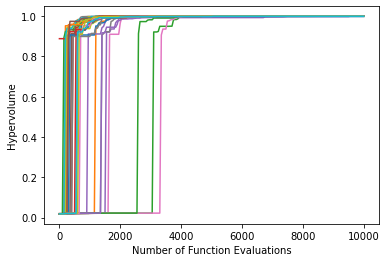

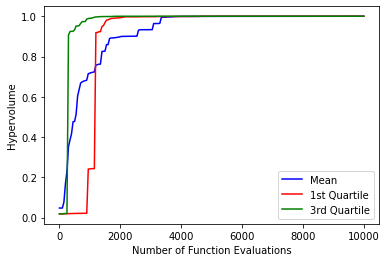

Hypervolume computation for 30 Epsilon MOEA runs using truss model
Reading and computing hypervolumes for run 0
Reading and computing hypervolumes for run 1
Reading and computing hypervolumes for run 2
Reading and computing hypervolumes for run 3
Reading and computing hypervolumes for run 4
Reading and computing hypervolumes for run 5
Reading and computing hypervolumes for run 6
Reading and computing hypervolumes for run 7
Reading and computing hypervolumes for run 8
Reading and computing hypervolumes for run 9
Reading and computing hypervolumes for run 10
Reading and computing hypervolumes for run 11
Reading and computing hypervolumes for run 12
Reading and computing hypervolumes for run 13
Reading and computing hypervolumes for run 14
Reading and computing hypervolumes for run 15
Reading and computing hypervolumes for run 16
Reading and computing hypervolumes for run 17
Reading and computing hypervolumes for run 18
Reading and computing hypervolumes for run 19
Reading and computing h

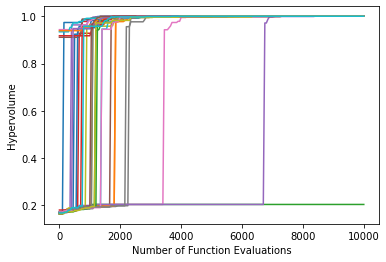

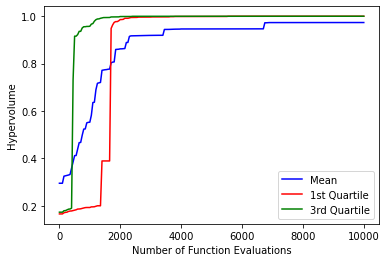

Hypervolume computation for 30 AOS runs using fibre stiffness model
Reading and computing hypervolumes for run 0
Reading and computing hypervolumes for run 1
Reading and computing hypervolumes for run 2
Reading and computing hypervolumes for run 3
Reading and computing hypervolumes for run 4
Reading and computing hypervolumes for run 5
Reading and computing hypervolumes for run 6
Reading and computing hypervolumes for run 7
Reading and computing hypervolumes for run 8
Reading and computing hypervolumes for run 9
Reading and computing hypervolumes for run 10
Reading and computing hypervolumes for run 11
Reading and computing hypervolumes for run 12
Reading and computing hypervolumes for run 13
Reading and computing hypervolumes for run 14
Reading and computing hypervolumes for run 15
Reading and computing hypervolumes for run 16
Reading and computing hypervolumes for run 17
Reading and computing hypervolumes for run 18
Reading and computing hypervolumes for run 19
Reading and computing 

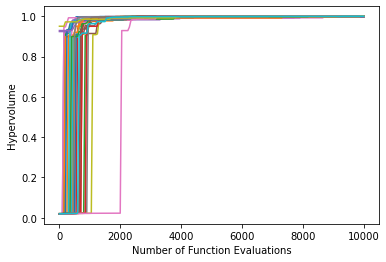

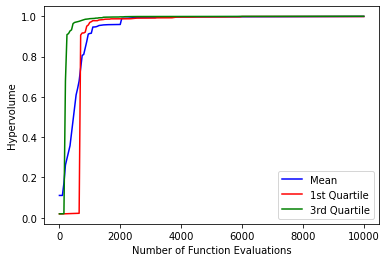

In [4]:
#### Program Operation

# set to: true - to read results for fibre stiffness model run
#         false - to read results for truss model run
model_fib = True

# set to: true - if Epsilon MOEA was used
#         false - if AOS MOEA was used
alg_eps_moea = True

number_runs = 30

# Name for saving plots
def determine_savename(fibre_model, eps_algorithm):
    if fibre_model:
        savename1 = 'fib_'
    else:
        savename1 = 'truss_'
        
    if eps_algorithm:
        savename2 = 'eps_'
    else:
        savename2 = 'aos_'
        
    return savename1+savename2

# For Epsilon MOEA runs using fibre stiffness model 
print('Hypervolume computation for ' + str(number_runs) + ' Epsilon MOEA runs using fibre stiffness model')
hv_dict_fib_eps, nfe_dict_fib_eps, hv_mean_fib_eps, hv_1q_fib_eps, hv_3q_fib_eps, nfe_jump_fib_eps = compute_hypervolume_allruns(model_fib, alg_eps_moea, number_runs)
savename_eps_fib = determine_savename(model_fib, alg_eps_moea)
plot_hypervolume_allruns(hv_dict_fib_eps, nfe_dict_fib_eps, hv_mean_fib_eps, hv_1q_fib_eps, hv_3q_fib_eps, number_runs, savename_eps_fib)

# For Epsilon MOEA runs using truss stiffness model 
print('Hypervolume computation for ' + str(number_runs) + ' Epsilon MOEA runs using truss model')
hv_dict_truss_eps, nfe_dict_truss_eps, hv_mean_truss_eps, hv_1q_truss_eps, hv_3q_truss_eps, nfe_jump_truss_eps = compute_hypervolume_allruns(not model_fib, alg_eps_moea, number_runs)
savename_eps_truss = determine_savename(not model_fib, alg_eps_moea)
plot_hypervolume_allruns(hv_dict_truss_eps, nfe_dict_truss_eps, hv_mean_truss_eps, hv_1q_truss_eps, hv_3q_truss_eps, number_runs, savename_eps_truss)

# For AOS runs using fibre stiffness model 
print('Hypervolume computation for ' + str(number_runs) + ' AOS runs using fibre stiffness model')
hv_dict_fib_aos, nfe_dict_fib_aos, hv_mean_fib_aos, hv_1q_fib_aos, hv_3q_fib_aos, nfe_jump_fib_aos = compute_hypervolume_allruns(model_fib, not alg_eps_moea, number_runs)
savename_aos_fib = determine_savename(model_fib, not alg_eps_moea)
plot_hypervolume_allruns(hv_dict_fib_aos, nfe_dict_fib_aos, hv_mean_fib_aos, hv_1q_fib_aos, hv_3q_fib_aos, number_runs, savename_aos_fib)

# For AOS runs using truss stiffness model 
#print('Hypervolume computation for ' + str(number_runs) + ' AOS runs using truss model')
#hv_dict_aos_truss, nfe_dict_aos_truss, hv_mean_aos_truss, hv_1q_aos_truss, hv_3q_aos_truss, nfe_jump_aos_truss = compute_hypervolume_allruns(not model_fib, not alg_eps_moea, number_runs)
#savename_aos_truss = determine_savename(not model_fib, not alg_eps_moea)
#plot_hypervolume_allruns(hv_dict_aos_truss, nfe_dict_aos_truss, hv_mean_aos_truss, hv_1q_aos_truss, hv_3q_aos_truss, number_runs, savename_aos_truss)


Hypervolume computation for 30 AOS runs using truss model
Reading and computing hypervolumes for run 0
Reading and computing hypervolumes for run 1
Reading and computing hypervolumes for run 2
Reading and computing hypervolumes for run 3
Reading and computing hypervolumes for run 4
Reading and computing hypervolumes for run 5
Reading and computing hypervolumes for run 6
Reading and computing hypervolumes for run 7
Reading and computing hypervolumes for run 8
Reading and computing hypervolumes for run 9
Reading and computing hypervolumes for run 10
Reading and computing hypervolumes for run 11
Reading and computing hypervolumes for run 12
Reading and computing hypervolumes for run 13
Reading and computing hypervolumes for run 14
Reading and computing hypervolumes for run 15
Reading and computing hypervolumes for run 16
Reading and computing hypervolumes for run 17
Reading and computing hypervolumes for run 18
Reading and computing hypervolumes for run 19
Reading and computing hypervolum

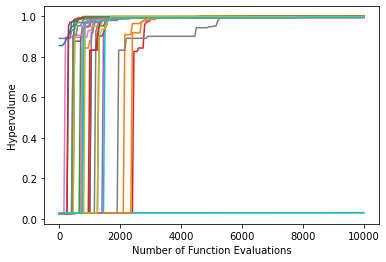

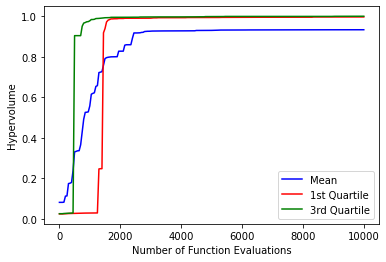

In [5]:
# For AOS runs using truss stiffness model 
print('Hypervolume computation for ' + str(number_runs) + ' AOS runs using truss model')
hv_dict_aos_truss, nfe_dict_aos_truss, hv_mean_aos_truss, hv_1q_aos_truss, hv_3q_aos_truss, nfe_jump_aos_truss = compute_hypervolume_allruns(not model_fib, not alg_eps_moea, number_runs)
savename_aos_truss = determine_savename(not model_fib, not alg_eps_moea)
plot_hypervolume_allruns(hv_dict_aos_truss, nfe_dict_aos_truss, hv_mean_aos_truss, hv_1q_aos_truss, hv_3q_aos_truss, number_runs, savename_aos_truss)

Text(0.5, 1.0, 'Boxplot for NFE to clear feasibility threshold')

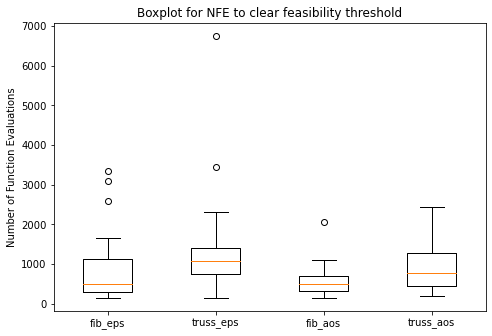

In [7]:
##### BOX PLOTS FOR NFE TO OVERCOME FEASIBILITY BARRIER

fig3 = plt.figure(1)
ax = fig3.add_axes([0,0,1,1])
bp = ax.boxplot([nfe_jump_fib_eps,nfe_jump_truss_eps,nfe_jump_fib_aos,nfe_jump_aos_truss])
#bp = ax.boxplot([nfe_jump_fib_eps,nfe_jump_truss_eps,nfe_jump_fib_aos])
ax.set_xticklabels(['fib_eps','truss_eps','fib_aos','truss_aos'])
#ax.set_xticklabels(['fib_eps','truss_eps','fib_aos'])
plt.ylabel('Number of Function Evaluations')
plt.title('Boxplot for NFE to clear feasibility threshold')
#fig3.savefig('NFE_boxplot.png')
